In [4]:
import sys
sys.path.append('../../')

from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
from hnlpy.timeop import makefiltersos
from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter
from scipy.fftpack import fft
from scipy import stats # for zscoring

from sklearn.covariance import GraphicalLassoCV

from numpy.polynomial.polynomial import polyfit, polyval

import matplotlib.pyplot as plt

/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/utils/multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, 

In [5]:
# organize file in post-stoke days sequence
filedir="../../"
pathname = 'archive/EEG_stroke_62_cleaned/'
filedates=[n for n in range(3)]
numSes=len(filedates)

In [43]:
n=0
filename=filedir+pathname+str(filedates[n])+'.mat'
data = loadmat(filename)
Fs=int(data['Fs'][0])
ch_dubious=data['ch_dubious'][0]
ch_peripheral=data['ch_peripheral'][0]
chanlocs=data['chanlocs'][0]
preprocessed_eeg=np.transpose(data['preprocessed_eeg'])
subject_ID=int(data['subject_ID'][0])


Text(0.5, 0, 'frequency (Hz)')

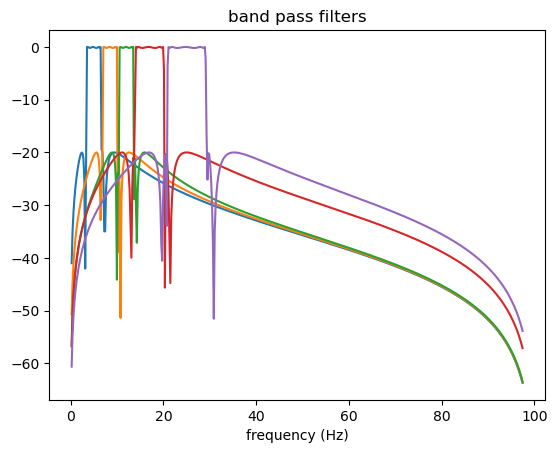

In [39]:
# build the narrow band filters
srnew = 200 
downsample = 10 
# passbands = [[1,3],[3.5,6.5],[7,10],[10.5,13.5],[14 ,20],[21,29],[30,49.5]]
# stopbands = [[0.75,3.25],[3.25,6.75],[6.75,10.25],[10.25,13.75],[13.75,20.5],[20.5,29.5],[29.5,50]]
# bandlabels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']
passbands = [[3.5,6.5],[7,10],[10.5,13.5],[14 ,20],[21,29]]
stopbands = [[3.25,6.75],[6.75,10.25],[10.25,13.75],[13.75,20.5],[20.5,29.5]]
bandlabels = ['Theta','Alpha','Mu','Beta1','Beta2']
esos = dict()
for j in range(len(passbands)):
    esos[j],w,h = narrowfilter(passbands[j],stopbands[j],samplingrate = srnew)
    plt.plot(w[1:500],20*np.log10(np.abs(h[1:500])))
plt.title('band pass filters')
plt.xlabel('frequency (Hz)')

In [40]:
# make a low pass filter @ 50 Hz 
sos_low, w,h = makefiltersos(Fs,50,55)

In [41]:
ncv = 5
pc_lasso = GraphicalLassoCV(cv=ncv, n_jobs=-5)

In [44]:
frequency = 4
filtdata = sosfiltfilt(esos[frequency],preprocessed_eeg,axis = 0,padtype ='odd')
hilbertdata = hilbert(filtdata,axis = 0)
# Combine real and imaginary parts
chanDataReal = np.concatenate((np.real(hilbertdata), np.imag(hilbertdata)), axis=1)
# Normalize data
chanDataReal = chanDataReal * (1 / np.mean(np.abs(chanDataReal)))
cov_matrix = np.cov(chanDataReal.T)

In [58]:
pc_lasso.fit(chanDataReal)
precision = pc_lasso.precision_
y = np.diag(precision)
yy = np.outer(y,y)
yy = np.sqrt(yy)
precision = precision/yy

/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bo

FloatingPointError: The system is too ill-conditioned for this solver. The system is too ill-conditioned for this solver